<a href="https://colab.research.google.com/github/AbduzZami/ColabNotebooks/blob/main/mobile%20shenzen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shadmansobhan_combined_dataset_pt1_path = kagglehub.dataset_download('shadmansobhan/combined-dataset-pt1')

print('Data source import complete.')


Using Colab cache for faster access to the 'combined-dataset-pt1' dataset.
Data source import complete.


In [2]:
ENCODER_NAME='mobilenet_v2' # efficientnet_b0 efficientnet_b1 resnet50 densenet121 mobilenet_v2
NUM_CLASS_SEG=2
NUM_CLASS_CLS=2
MODE=0
DATASET_NAME='C2_Shenzhen_Classification_TB'
BATCH_SIZE= 64 if DATASET_NAME == 'C2_Shenzhen_Classification_TB' else 64

In [3]:
!pip install torchinfo

In [4]:
import os
import random
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from torchvision.models.efficientnet import efficientnet_b0, EfficientNet_B0_Weights

import albumentations as album
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

from sklearn.metrics import classification_report

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import numpy as np

import torch.nn.functional as F

Using device: cuda


# Model Define

In [5]:
# # SeparableConv2d remains unchanged
# class SeparableConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
#         super().__init__()
#         self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
#         self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

#     def forward(self, x):
#         return self.pointwise(self.depthwise(x))

# # ASPP remains unchanged
# class ASPP(nn.Module):
#     def __init__(self, in_channels, out_channels, atrous_rates):
#         super().__init__()
#         modules = [
#             nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             )
#         ]
#         for rate in atrous_rates:
#             modules.append(nn.Sequential(
#                 SeparableConv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             ))
#         modules.append(nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(in_channels, out_channels, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         ))
#         self.convs = nn.ModuleList(modules)
#         self.project = nn.Sequential(
#             nn.Conv2d((len(atrous_rates) + 2) * out_channels, out_channels, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(0.5)
#         )

#     def forward(self, x):
#         size = x.shape[2:]
#         res = [F.interpolate(conv(x), size=size, mode='bilinear', align_corners=True) if i == len(self.convs)-1 else conv(x) for i, conv in enumerate(self.convs)]
#         return self.project(torch.cat(res, dim=1))

# # MFF Block
# class MFFBlock(nn.Module):
#     def __init__(self, in_channels_low, in_channels_high, out_channels):
#         super().__init__()
#         self.low_proj = nn.Conv2d(in_channels_low, out_channels, 1, bias=False)
#         self.high_proj = nn.Conv2d(in_channels_high, out_channels, 1, bias=False)
#         self.fusion = nn.Sequential(
#             nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(out_channels, out_channels // 8, 1),
#             nn.ReLU(),
#             nn.Conv2d(out_channels // 8, out_channels, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, low_feat, high_feat):
#         high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=True)
#         low_feat = self.low_proj(low_feat)
#         high_feat = self.high_proj(high_feat)
#         x = low_feat + high_feat
#         x = self.fusion(x)
#         return x * self.se(x)

# # CAFSE Block
# class CAFSEBlock(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.coarse = nn.Sequential(
#             nn.Conv2d(channels, channels, 3, padding=1),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(inplace=True)
#         )
#         self.fine = nn.Sequential(
#             nn.Conv2d(channels, channels, 1),
#             nn.BatchNorm2d(channels),
#             nn.Sigmoid()
#         )

#     def forward(self, decoder_feat, aspp_feat):
#         aspp_feat = F.interpolate(aspp_feat, size=decoder_feat.shape[2:], mode='bilinear', align_corners=True)
#         coarse = self.coarse(aspp_feat)
#         fine = self.fine(decoder_feat)
#         return decoder_feat + coarse * fine

# # Decoder remains unchanged
# class Decoder(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 48, 1, bias=False),
#             nn.BatchNorm2d(48),
#             nn.ReLU(inplace=True)
#         )
#         self.fuse = nn.Sequential(
#             SeparableConv2d(96, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             SeparableConv2d(out_channels, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(0.3)
#         )

#     def forward(self, x, low_level_feat):
#         x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=True)
#         x = self.conv1(x)
#         x = torch.cat([x, low_level_feat], dim=1)
#         return self.fuse(x)

# # Main model
# class DeepLabV3Plus_EfficientNet(nn.Module):
#     def __init__(self, num_classes_seg=1, num_classes_cls=2, mode=1, output_stride=16, activation='sigmoid'):
#         super().__init__()
#         self.mode = mode
#         self.output_stride = output_stride

#         backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
#         features = list(backbone.features.children())
#         if output_stride == 16:
#             self.low_level = nn.Sequential(*features[:3])
#             self.high_level = nn.Sequential(*features[3:])
#         else:
#             self.low_level = nn.Sequential(*features[:2])
#             self.high_level = nn.Sequential(*features[2:])

#         low_level_channels = 24 if output_stride == 16 else 16
#         self.low_proj = nn.Sequential(
#             nn.Conv2d(low_level_channels, 48, 1, bias=False),
#             nn.BatchNorm2d(48),
#             nn.ReLU(inplace=True)
#         )

#         atrous_rates = [6, 12, 18] if output_stride == 16 else [12, 24, 36]
#         self.aspp = ASPP(1280, 256, atrous_rates)
#         self.mff = MFFBlock(48, 256, 256)
#         self.decoder = Decoder(256, 256)
#         self.cafse = CAFSEBlock(256)
#         self.final_conv = nn.Conv2d(256, num_classes_seg, 1)

#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Flatten(),
#             nn.Linear(1280, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, num_classes_cls)
#         )

#         if activation == 'sigmoid':
#             self.activation = nn.Sigmoid()
#         elif activation == 'softmax2d':
#             self.activation = nn.Softmax2d()
#         else:
#             self.activation = None

#     def forward(self, x):
#         input_size = x.size()[2:]
#         low_feat = self.low_level(x)
#         high_feat = self.high_level(low_feat)
#         low_proj = self.low_proj(low_feat)

#         if self.mode == 0:
#             out = self.classifier(high_feat)
#             return out
#         elif self.mode == 1:
#             aspp_out = self.aspp(high_feat)
#             mff_out = self.mff(low_proj, aspp_out)
#             decoder_out = self.decoder(mff_out, low_proj)
#             cafse_out = self.cafse(decoder_out, aspp_out)
#             out = self.final_conv(cafse_out)
#             out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
#             if self.activation is not None:
#                 out = self.activation(out)
#             return out
#         else:
#             raise ValueError("Mode must be 0 (classification) or 1 (segmentation)")


In [6]:
# model = DeepLabV3Plus_EfficientNet(num_classes_seg=2, num_classes_cls=2, mode=0)  # mode=1 for segmentation
# model = model.to(DEVICE)

# # Input image
# input_tensor = torch.randn(2, 3, 256, 256).to(DEVICE)

# # Forward pass
# output = model(input_tensor)
# print(output.shape)

# def print_model_parameters(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     non_trainable_params = total_params - trainable_params

#     print(f"Total Parameters: {total_params:,}")
#     print(f"Trainable Parameters: {trainable_params:,}")
#     print(f"Non-Trainable Parameters: {non_trainable_params:,}")

# # Example usage
# print_model_parameters(model)

# summary(model, input_size=(2, 3, 256, 256))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# SeparableConv2d
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

# ASPP
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super().__init__()
        modules = [
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        ]
        for rate in atrous_rates:
            modules.append(nn.Sequential(
                SeparableConv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        modules.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))
        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d((len(atrous_rates) + 2) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)
        )

    def forward(self, x):
        # print(f"ASPP input shape: {x.shape}")
        size = x.shape[2:]
        res = [F.interpolate(conv(x), size=size, mode='bilinear', align_corners=True) if i == len(self.convs)-1 else conv(x) for i, conv in enumerate(self.convs)]
        concatenated = torch.cat(res, dim=1)
        # print(f"ASPP concatenated shape: {concatenated.shape}")
        return self.project(concatenated)

# MFFBlock
class MFFBlock(nn.Module):
    def __init__(self, in_channels_low, in_channels_high, out_channels):
        super().__init__()
        self.low_proj = nn.Conv2d(in_channels_low, out_channels, 1, bias=False)
        self.high_proj = nn.Conv2d(in_channels_high, out_channels, 1, bias=False)
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(out_channels // 8, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        # print(f"MFFBlock low_feat shape: {low_feat.shape}")
        # print(f"MFFBlock high_feat shape: {high_feat.shape}")
        high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=True)
        low_feat = self.low_proj(low_feat)
        high_feat = self.high_proj(high_feat)
        x = low_feat + high_feat
        x = self.fusion(x)
        return x * self.se(x)

# CAFSEBlock
class CAFSEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.coarse = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.fine = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )

    def forward(self, decoder_feat, aspp_feat):
        # print(f"CAFSEBlock decoder_feat shape: {decoder_feat.shape}")
        # print(f"CAFSEBlock aspp_feat shape: {aspp_feat.shape}")
        aspp_feat = F.interpolate(aspp_feat, size=decoder_feat.shape[2:], mode='bilinear', align_corners=True)
        coarse = self.coarse(aspp_feat)
        fine = self.fine(decoder_feat)
        return decoder_feat + coarse * fine

# Decoder
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.fuse = nn.Sequential(
            SeparableConv2d(96, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SeparableConv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)
        )

    def forward(self, x, low_level_feat):
        # print(f"Decoder input x shape: {x.shape}")
        # print(f"Decoder low_level_feat shape: {low_level_feat.shape}")
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = torch.cat([x, low_level_feat], dim=1)
        return self.fuse(x)

# DeepLabV3Plus
class DeepLabV3Plus(nn.Module):
    def __init__(self, encoder_name='resnet50', bridge='ASPP', num_classes_seg=2, num_classes_cls=2, mode=1, output_stride=16):
        super().__init__()
        self.encoder_name = encoder_name
        self.bridge = bridge
        self.mode = mode
        self.output_stride = output_stride

        # Encoder configuration
        self.encoder_config = {
            'resnet18': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                         'low_level_channels': 64, 'high_level_channels': 512, 'stride_adjustable': True},
            'resnet34': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                         'low_level_channels': 64, 'high_level_channels': 512, 'stride_adjustable': True},
            'resnet50': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                         'low_level_channels': 256, 'high_level_channels': 2048, 'stride_adjustable': True},
            'resnet101': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                          'low_level_channels': 256, 'high_level_channels': 2048, 'stride_adjustable': True},
            'resnet152': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                          'low_level_channels': 256, 'high_level_channels': 2048, 'stride_adjustable': True},
            'densenet121': {'low_level_layer': 'features.transition1', 'high_level_layer': 'features',
                            'low_level_channels': 128, 'high_level_channels': 1024, 'stride_adjustable': False},
            'densenet169': {'low_level_layer': 'features.transition1', 'high_level_layer': 'features',
                            'low_level_channels': 128, 'high_level_channels': 1664, 'stride_adjustable': False},
            'densenet201': {'low_level_layer': 'features.transition1', 'high_level_layer': 'features',
                            'low_level_channels': 128, 'high_level_channels': 1920, 'stride_adjustable': False},
            'efficientnet_b0': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 24, 'high_level_channels': 320, 'stride_adjustable': False},
            'efficientnet_b1': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 24, 'high_level_channels': 320, 'stride_adjustable': False},
            'efficientnet_b2': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 24, 'high_level_channels': 352, 'stride_adjustable': False},
            'efficientnet_b3': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 32, 'high_level_channels': 384, 'stride_adjustable': False},
            'efficientnet_b4': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 32, 'high_level_channels': 448, 'stride_adjustable': False},
            'efficientnet_b5': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 40, 'high_level_channels': 512, 'stride_adjustable': False},
            'efficientnet_b6': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 40, 'high_level_channels': 576, 'stride_adjustable': False},
            'efficientnet_b7': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 48, 'high_level_channels': 640, 'stride_adjustable': False},
            'mobilenet_v2': {'low_level_layer': 'features.4', 'high_level_layer': 'features.18',
                             'low_level_channels': 32, 'high_level_channels': 1280, 'stride_adjustable': False},
        }

        if encoder_name not in self.encoder_config:
            raise ValueError(f"Unsupported encoder: {encoder_name}. Supported: {list(self.encoder_config.keys())}")

        config = self.encoder_config[encoder_name]

        # Load the encoder with pretrained weights
        try:
            from torchvision.models import densenet121, DenseNet121_Weights, mobilenet_v2, MobileNet_V2_Weights
            if encoder_name == 'densenet121':
                self.encoder = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
            elif encoder_name == 'mobilenet_v2':
                self.encoder = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
                # Adjust stride in features.2 to achieve 64x64 at features.4
                if output_stride == 16:
                    self.encoder.features[2].conv[1].stride = (1, 1)  # Set stride to 1
            else:
                self.encoder = getattr(models, encoder_name)(pretrained=True)
        except ImportError:
            self.encoder = getattr(models, encoder_name)(pretrained=True)

        # Adjust strides for ResNet
        if config['stride_adjustable'] and output_stride != 32:
            if encoder_name.startswith('resnet'):
                if output_stride == 16:
                    self.encoder.layer4[0].conv2.stride = (1, 1)
                    self.encoder.layer4[0].downsample[0].stride = (1, 1)
                elif output_stride == 8:
                    self.encoder.layer3[0].conv2.stride = (1, 1)
                    self.encoder.layer3[0].downsample[0].stride = (1, 1)
                    self.encoder.layer4[0].conv2.stride = (1, 1)
                    self.encoder.layer4[0].downsample[0].stride = (1, 1)

        # Remove classification head
        if encoder_name.startswith('resnet'):
            self.encoder.fc = nn.Identity()
            self.encoder.avgpool = nn.Identity()
        elif encoder_name.startswith('densenet'):
            self.encoder.classifier = nn.Identity()
        elif encoder_name.startswith('efficientnet'):
            self.encoder.classifier = nn.Identity()
            self.encoder.avgpool = nn.Identity()
        elif encoder_name == 'mobilenet_v2':
            self.encoder.classifier = nn.Identity()

        # Low-level feature projection
        self.low_proj = nn.Sequential(
            nn.Conv2d(config['low_level_channels'], 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        # ASPP
        dilations = [6, 12, 18] if output_stride == 16 else [12, 24, 36]
        if bridge == 'ASPP':
            self.aspp = ASPP(config['high_level_channels'], 256, dilations)
        else:
            raise ValueError(f"Unsupported bridge: {bridge}. Only 'ASPP' is supported.")

        # MFF, CAFSE, and Decoder
        self.mff = MFFBlock(48, 256, 256)
        self.decoder = Decoder(256, 256)
        self.cafse = CAFSEBlock(256)
        self.final_conv = nn.Conv2d(256, num_classes_seg, 1)

        # Classifier for mode=0
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(config['high_level_channels'], 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_cls)
        )

        self.activation = nn.Sigmoid()

    def forward(self, x):
        input_size = x.size()[2:]
        # print(f"Input shape: {x.shape}")

        # Feature extraction
        if self.encoder_name.startswith('resnet'):
            x = self.encoder.conv1(x)
            x = self.encoder.bn1(x)
            x = self.encoder.relu(x)
            x = self.encoder.maxpool(x)
            x_low = self.encoder.layer1(x)
            x = self.encoder.layer2(x_low)
            x = self.encoder.layer3(x)
            x_high = self.encoder.layer4(x)
        elif self.encoder_name.startswith('densenet'):
            x = self.encoder.features.conv0(x)
            x = self.encoder.features.norm0(x)
            x = self.encoder.features.relu0(x)
            x = self.encoder.features.pool0(x)
            x = self.encoder.features.denseblock1(x)
            x_low = self.encoder.features.transition1(x)
            x = self.encoder.features.denseblock2(x_low)
            x = self.encoder.features.transition2(x)
            x = self.encoder.features.denseblock3(x)
            x = self.encoder.features.transition3(x)
            x = self.encoder.features.denseblock4(x)
            x_high = self.encoder.features.norm5(x)
            x_high = F.relu(x_high, inplace=True)
        elif self.encoder_name.startswith('efficientnet'):
            x = self.encoder.features[0](x)
            x = self.encoder.features[1](x)
            x_low = self.encoder.features[2](x)
            x = self.encoder.features[3](x_low)
            x = self.encoder.features[4](x)
            x = self.encoder.features[5](x)
            x = self.encoder.features[6](x)
            x_high = self.encoder.features[7](x)
        elif self.encoder_name == 'mobilenet_v2':
            x = self.encoder.features[0](x)
            x = self.encoder.features[1](x)
            x = self.encoder.features[2](x)
            x = self.encoder.features[3](x)
            x_low = self.encoder.features[4](x)
            # print(f"x_low shape: {x_low.shape}")
            x = self.encoder.features[5](x_low)
            x = self.encoder.features[6](x)
            x = self.encoder.features[7](x)
            x = self.encoder.features[8](x)
            x = self.encoder.features[9](x)
            x = self.encoder.features[10](x)
            x = self.encoder.features[11](x)
            x = self.encoder.features[12](x)
            x = self.encoder.features[13](x)
            x = self.encoder.features[14](x)
            x = self.encoder.features[15](x)
            x = self.encoder.features[16](x)
            x = self.encoder.features[17](x)
            x_high = self.encoder.features[18](x)
            # print(f"x_high shape: {x_high.shape}")

        # Classification mode
        if self.mode == 0:
            out = self.classifier(x_high)
            return out

        # Segmentation mode
        low_proj = self.low_proj(x_low)
        # print(f"low_proj output shape: {low_proj.shape}")
        aspp_out = self.aspp(x_high)
        # print(f"aspp_out shape: {aspp_out.shape}")
        mff_out = self.mff(low_proj, aspp_out)
        # print(f"mff_out shape: {mff_out.shape}")
        decoder_out = self.decoder(mff_out, low_proj)
        # print(f"decoder_out shape: {decoder_out.shape}")
        cafse_out = self.cafse(decoder_out, aspp_out)
        # print(f"cafse_out shape: {cafse_out.shape}")
        out = self.final_conv(cafse_out)
        # print(f"final_conv output shape: {out.shape}")
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        out = self.activation(out)
        return out

# Function to print model parameters
def print_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-Trainable Parameters: {non_trainable_params:,}")

# Example usage
if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DeepLabV3Plus(encoder_name=ENCODER_NAME, num_classes_cls=NUM_CLASS_CLS, num_classes_seg=NUM_CLASS_SEG, mode=MODE).to(DEVICE)
    model = model.to(DEVICE)

    # Input image
    input_tensor = torch.randn(2, 3, 256, 256).to(DEVICE)

    # Forward pass
    output = model(input_tensor)
    print(f"Output shape: {output.shape}")

    # Print model parameters
    print_model_parameters(model)

    # Model summary using torchinfo
    try:
        from torchinfo import summary
        summary(model, input_size=(2, 3, 256, 256), device=DEVICE)
    except ImportError:
        print("torchinfo not installed. Install it using 'pip install torchinfo' for model summary.")


!pip install thop


import torch
import time
from scipy.stats import ttest_ind
import psutil
from thop import profile

# Dummy input (batch of 32, 3 channels, 256x256)
num_frames = 100
dummy_input = torch.randn(1, 3, 256, 256).cuda()

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


model.eval()

# Parameters
params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6  # Convert to millions
print(f"Params: {params:.2f} M")

# GFlops (using thop)
flops, params_thop = profile(model, inputs=(dummy_input,))  # Returns flops and params
gflops = flops / 1e9  # Convert to gigaflops
print(f"GFlops: {gflops:.2f} G")

# Memory
# Reset memory stats to ensure accurate measurement
torch.cuda.reset_peak_memory_stats(DEVICE)

# Measure model parameters memory
param_memory = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)  # MB
buffer_memory = sum(b.numel() * b.element_size() for b in model.buffers()) / (1024 * 1024)  # MB
model_memory = param_memory + buffer_memory
print(f"Model Parameters + Buffers Memory: {model_memory:.2f} MB")

# Measure memory during inference (including activations)
torch.cuda.synchronize()  # Ensure no pending operations
start_memory = torch.cuda.memory_allocated(DEVICE) / (1024 * 1024)  # MB
model(dummy_input)  # Run a forward pass
torch.cuda.synchronize()  # Wait for GPU operations to complete
peak_memory = torch.cuda.max_memory_allocated(DEVICE) / (1024 * 1024)  # MB
print(f"Peak Memory During Inference: {peak_memory:.2f} MB")
print(f"Memory Allocated for Input + Activations: {peak_memory - model_memory:.2f} MB")

# Optional: Reserved memory (includes cached memory by PyTorch)
reserved_memory = torch.cuda.memory_reserved(DEVICE) / (1024 * 1024)  # MB
print(f"Reserved Memory: {reserved_memory:.2f} MB")

# FPS
start = time.time()
for _ in range(num_frames):
    model(dummy_input)
torch.cuda.synchronize()  # Ensure GPU operations complete
fps = num_frames / (time.time() - start)
print(f"FPS: {fps:.2f}")

print("--------[RESOURCE INFO]---------")
print(f"Params: {params:.2f} M")
print(f"GFlops: {gflops:.2f} G")
# print(f"Memory: {memory:.2f} MB")
print(f"FPS: {fps:.2f}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 106MB/s] 


Output shape: torch.Size([2, 2])
Total Parameters: 6,335,044
Trainable Parameters: 6,335,044
Non-Trainable Parameters: 0
Using device: cuda
Params: 6.34 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
GFlops: 0.43 G
Model Parameters + Buffers Memory: 24.32 MB
Peak Memory During Inference: 329.26 MB
Memory Allocated for Input + Activations: 304.94 MB
Reserved Memory: 338.00 MB
FPS: 75.59
--------[RE

# Dataframe

In [8]:
shadmansobhan_combined_dataset_pt1_path

'/kaggle/input/combined-dataset-pt1'

In [9]:
# Define paths
data_dir_train = f'{shadmansobhan_combined_dataset_pt1_path}/{DATASET_NAME}/train'
data_dir_test = f'{shadmansobhan_combined_dataset_pt1_path}/{DATASET_NAME}/test'
# Load filepaths and labels
filepaths, labels = [], []

for fold in os.listdir(data_dir_train):
    foldpath = os.path.join(data_dir_train, fold)
    for file in os.listdir(foldpath):
        filepaths.append(os.path.join(foldpath, file))
        labels.append(fold)

# Create full training dataframe
train_df_full = pd.DataFrame({"image_path": filepaths, "label": labels})

# Split into train and validation sets
train_df, valid_df = train_test_split(train_df_full, test_size=0.2, random_state=42, stratify=train_df_full['label'])

# Load test data
test_filepaths, test_labels = [], []
for fold in os.listdir(data_dir_test):
    foldpath = os.path.join(data_dir_test, fold)
    for file in os.listdir(foldpath):
        test_filepaths.append(os.path.join(foldpath, file))
        test_labels.append(fold)

test_df = pd.DataFrame({"image_path": test_filepaths, "label": test_labels})


# Map class names to indices
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(train_df['label'].unique()))}
print("Class to index mapping:", class_to_idx)

Class to index mapping: {'Normal': 0, 'Tuberculosis': 1}


In [10]:
# Custom Dataset Class
class MyDataGenerator(Dataset):
    def __init__(self, df, class_to_idx, augmentation=None, preprocessing=None):
        self.image_paths = df['image_path'].tolist()
        self.labels = df['label'].map(class_to_idx).tolist()
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        image = cv2.imread(self.image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[i]

        if self.augmentation:
            image = self.augmentation(image=image)['image']

        if self.preprocessing:
            image = self.preprocessing(image=image)['image']

        return image, label


# Augmentations
def get_training_augmentation():
    return album.Compose([
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomRotate90(p=0.5),
        album.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
        album.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    ])

def get_validation_augmentation():
    return album.Compose([
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True,
                           border_mode=cv2.BORDER_CONSTANT, value=0)
    ])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing():
    return album.Compose([
        album.Resize(height=256, width=256, always_apply=True),
        album.Lambda(image=to_tensor)
    ])

In [11]:
# --- Compute Metrics Function ---
def compute_metrics(outputs, labels, calc_auc=False):
    _, preds = torch.max(outputs, 1)
    labels_cpu = labels.cpu()
    preds_cpu = preds.cpu()

    acc = accuracy_score(labels_cpu, preds_cpu)
    prec = precision_score(labels_cpu, preds_cpu, average='macro')
    rec = recall_score(labels_cpu, preds_cpu, average='macro')
    f1 = f1_score(labels_cpu, preds_cpu, average='macro')

    auc = float('nan')
    if calc_auc:
        probs = F.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
        labels_np = labels_cpu.numpy()
        try:
            auc = roc_auc_score(labels_np, probs)
        except ValueError:
            pass

    return acc, prec, rec, f1, auc


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, metric='val_loss'):
        self.patience = patience
        self.min_delta = min_delta
        self.metric = metric
        self.best_score = None
        self.wait = 0
        self.stop_training = False

    def __call__(self, metrics_dict):
        raw_score = metrics_dict[self.metric]

        # Determine if this metric should be minimized (e.g., val_loss) or maximized (e.g., accuracy)
        minimize = self.metric == 'val_loss'
        current_score = -raw_score if minimize else raw_score

        # Initialize best score if first epoch
        if self.best_score is None:
            self.best_score = current_score
            self.wait = 0
        elif current_score < self.best_score + self.min_delta:
            self.wait += 1
            print(f"No improvement in {self.metric}. Wait: {self.wait}/{self.patience}")
            if self.wait >= self.patience:
                self.stop_training = True
                print("Early stopping triggered!")
        else:
            self.best_score = current_score
            self.wait = 0

        # Debug print in original metric scale
        best_raw = -self.best_score if minimize else self.best_score
        print(f"[DEBUG] {self.metric}: Current={raw_score:.6f}, Best={best_raw:.6f}")

# Dataloaders
train_dataset = MyDataGenerator(train_df, class_to_idx, get_training_augmentation(), get_preprocessing())
valid_dataset = MyDataGenerator(valid_df, class_to_idx, get_validation_augmentation(), get_preprocessing())
test_dataset = MyDataGenerator(test_df, class_to_idx, get_validation_augmentation(), get_preprocessing())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=1e-9)


# Train

In [12]:
# --- Initialize Metric Trackers ---
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
train_precs, valid_precs = [], []
train_recs, valid_recs = [], []
train_f1s, valid_f1s = [], []

EPOCHS = 100
best_acc = 0.0
early_stopping = EarlyStopping(patience=30, min_delta=1e-20, metric='val_loss')

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_acc = train_prec = train_rec = train_f1 = 0.0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc, prec, rec, f1, _ = compute_metrics(outputs, labels, calc_auc=False)
        train_loss += loss.item() * images.size(0)
        train_acc += acc * images.size(0)
        train_prec += prec * images.size(0)
        train_rec += rec * images.size(0)
        train_f1 += f1 * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    train_prec /= len(train_loader.dataset)
    train_rec /= len(train_loader.dataset)
    train_f1 /= len(train_loader.dataset)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_precs.append(train_prec)
    train_recs.append(train_rec)
    train_f1s.append(train_f1)

    model.eval()
    valid_loss = 0.0
    valid_acc = valid_prec = valid_rec = valid_f1 = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            outputs = model(images)
            loss = criterion(outputs, labels)

            acc, prec, rec, f1, _ = compute_metrics(outputs, labels, calc_auc=False)
            valid_loss += loss.item() * images.size(0)
            valid_acc += acc * images.size(0)
            valid_prec += prec * images.size(0)
            valid_rec += rec * images.size(0)
            valid_f1 += f1 * images.size(0)

    valid_loss /= len(valid_loader.dataset)
    valid_acc /= len(valid_loader.dataset)
    valid_prec /= len(valid_loader.dataset)
    valid_rec /= len(valid_loader.dataset)
    valid_f1 /= len(valid_loader.dataset)

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    valid_precs.append(valid_prec)
    valid_recs.append(valid_rec)
    valid_f1s.append(valid_f1)

    print(f"Epoch {epoch}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}, F1={train_f1:.4f} | "
          f"Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}, Prec={valid_prec:.4f}, Rec={valid_rec:.4f}, F1={valid_f1:.4f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'SegClass_TB_CXR.pth')
        print("Model saved!")

    metrics_dict = {'val_loss': valid_loss}
    early_stopping(metrics_dict)
    if early_stopping.stop_training:
        print(f"Training stopped at epoch {epoch}")
        break

    scheduler.step()

# --- Print Total Time ---
end_time = time.time()
elapsed = end_time - start_time
print(f"\nTotal training time: {elapsed/60:.2f} minutes")


Epoch 0: Train Loss=0.8871, Acc=0.5674, Prec=0.5083, Rec=0.5715, F1=0.4773 | Valid Loss=0.3430, Acc=0.8774, Prec=0.8724, Rec=0.8866, F1=0.8664
Model saved!
[DEBUG] val_loss: Current=0.342998, Best=0.342998
Epoch 1: Train Loss=0.4990, Acc=0.7636, Prec=0.7685, Rec=0.7669, F1=0.7621 | Valid Loss=0.9636, Acc=0.7547, Prec=0.8003, Rec=0.7654, F1=0.7390
No improvement in val_loss. Wait: 1/30
[DEBUG] val_loss: Current=0.963640, Best=0.342998
Epoch 2: Train Loss=0.4564, Acc=0.8180, Prec=0.8214, Rec=0.8217, F1=0.8176 | Valid Loss=0.3955, Acc=0.8962, Prec=0.8824, Rec=0.8956, F1=0.8856
Model saved!
No improvement in val_loss. Wait: 2/30
[DEBUG] val_loss: Current=0.395540, Best=0.342998
Epoch 3: Train Loss=0.4290, Acc=0.8061, Prec=0.8107, Rec=0.8095, F1=0.8032 | Valid Loss=0.3676, Acc=0.8491, Prec=0.8539, Rec=0.8500, F1=0.8417
No improvement in val_loss. Wait: 3/30
[DEBUG] val_loss: Current=0.367553, Best=0.342998
Epoch 4: Train Loss=0.4191, Acc=0.8251, Prec=0.8371, Rec=0.8312, F1=0.8233 | Valid Lo

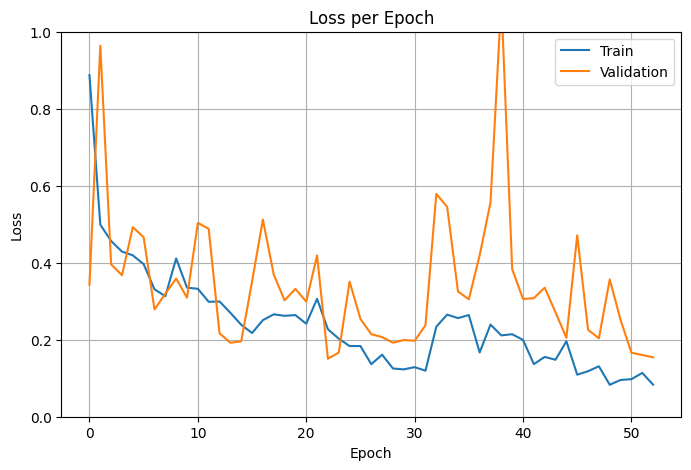

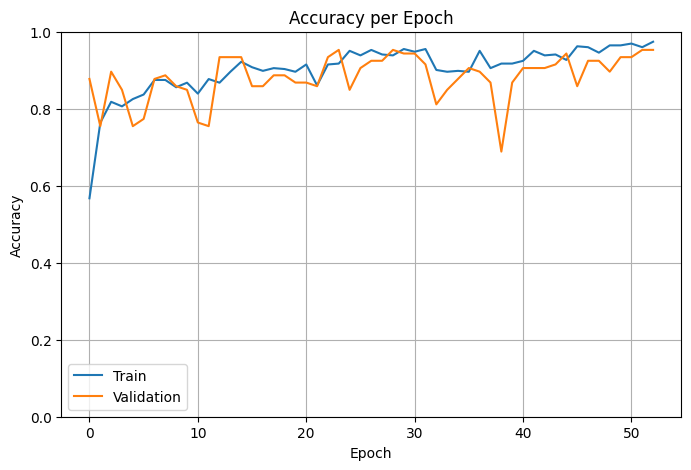

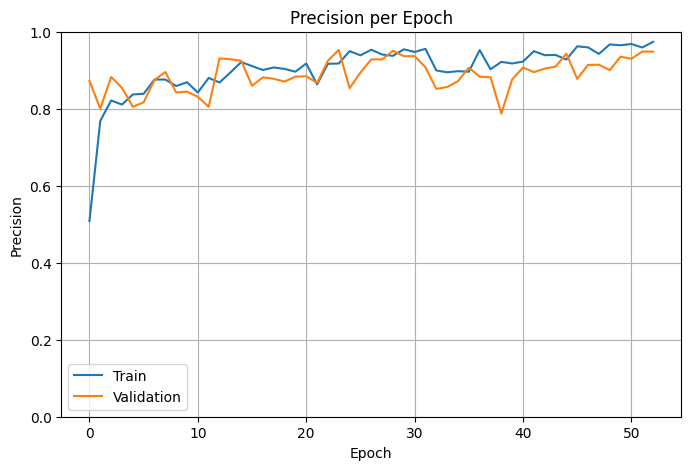

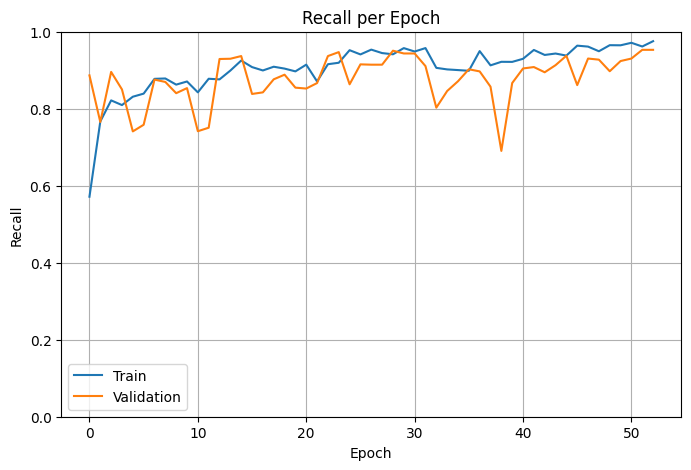

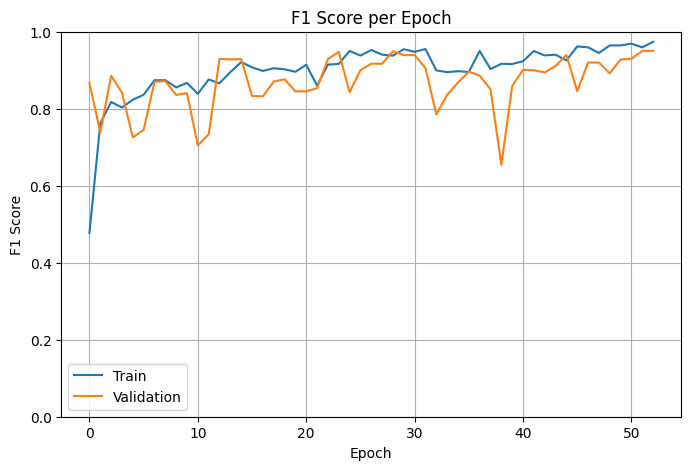

In [13]:

# --- Plotting Function ---
def plot_metrics(train_vals, valid_vals, ylabel, title):
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, label='Train')
    plt.plot(valid_vals, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Limit y-axis between 0 and 1
    plt.show()

# --- Plot Training/Validation Metrics ---
plot_metrics(train_losses, valid_losses, 'Loss', 'Loss per Epoch')
plot_metrics(train_accs, valid_accs, 'Accuracy', 'Accuracy per Epoch')
plot_metrics(train_precs, valid_precs, 'Precision', 'Precision per Epoch')
plot_metrics(train_recs, valid_recs, 'Recall', 'Recall per Epoch')
plot_metrics(train_f1s, valid_f1s, 'F1 Score', 'F1 Score per Epoch')

# Evaluation

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import torch.nn.functional as F
import numpy as np

# --- Testing ---
model.load_state_dict(torch.load('SegClass_TB_CXR.pth'))
model.eval()

test_loss = 0.0
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).long()
        outputs = model(images)
        loss = criterion(outputs, labels)

        probs = F.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.extend(probs[:, 1])  # For class 1 AUC
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        test_loss += loss.item() * images.size(0)

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute final metrics
n_samples = len(test_loader.dataset)
test_loss /= n_samples

test_acc = accuracy_score(all_labels, all_preds)
test_prec = precision_score(all_labels, all_preds, average='macro')
test_rec = recall_score(all_labels, all_preds, average='macro')
test_f1 = f1_score(all_labels, all_preds, average='macro')

try:
    test_auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    test_auc = float('nan')

print(f"\n📊 Test Results:")
print(f"  Loss={test_loss:.4f}")
print(f"  Accuracy={test_acc:.4f}")
print(f"  Precision={test_prec:.4f}")
print(f"  Recall={test_rec:.4f}")
print(f"  F1 Score={test_f1:.4f}")
print(f"  AUC={test_auc:.4f}")

print("\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Tuberculosis"]))
print(f"\nTotal training time: {elapsed/60:.2f} minutes")


📊 Test Results:
  Loss=0.3760
  Accuracy=0.8647
  Precision=0.8675
  Recall=0.8650
  F1 Score=0.8645
  AUC=0.9313

🔍 Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      0.91      0.87        66
Tuberculosis       0.90      0.82      0.86        67

    accuracy                           0.86       133
   macro avg       0.87      0.86      0.86       133
weighted avg       0.87      0.86      0.86       133


Total training time: 3.63 minutes


In [15]:
print("Test set class distribution:")
print(test_df['label'].value_counts(normalize=True))

Test set class distribution:
label
Tuberculosis    0.503759
Normal          0.496241
Name: proportion, dtype: float64


In [16]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Print full classification report
target_names = list(class_to_idx.keys())
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.83      0.91      0.87        66
Tuberculosis       0.90      0.82      0.86        67

    accuracy                           0.86       133
   macro avg       0.87      0.86      0.86       133
weighted avg       0.87      0.86      0.86       133



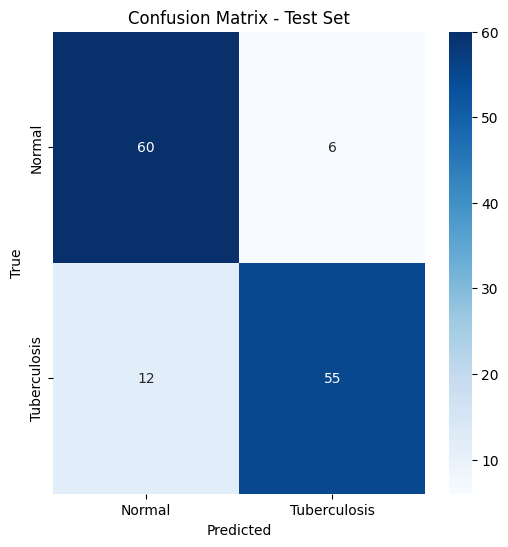

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_to_idx.keys(), yticklabels=class_to_idx.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

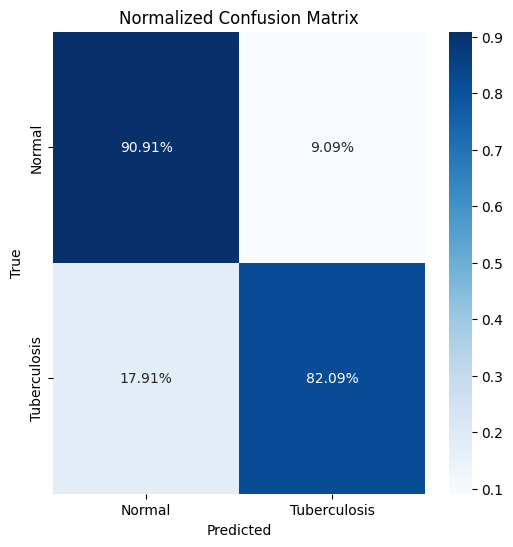

Misclassified indices: [  4  18  21  32  39  41  48  53  56  64  65  66  73  87  90  92  98 108]


In [18]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_to_idx.keys(), yticklabels=class_to_idx.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()
misclassified_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]
print("Misclassified indices:", misclassified_indices)

In [19]:
# import shutil

# source_dir = '/kaggle/working/Segmented_CXR'
# output_zip = '/kaggle/working/Segmented_CXR.zip'

# shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_dir)
# print(f"Zipped folder saved to: {output_zip}")
